<a href="https://colab.research.google.com/github/aicuai/coloso/blob/main/Coloso3/AICU_ComfyUI_LoRA_SDXL_Hollowstrawberry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ComfyUIマスター：カスタムノードとアプリ開発

## 第16講 LoRAの生成と機械学習の活用 https://j.aicu.ai/c3LoraXL

Ver.20241129

こちらは原作のスクリプトに日本語解説とサンプルデータセットへのリンクを組み込んだものになります。

不具合があった場合は原作の[こちら](https://colab.research.google.com/github/hollowstrawberry/kohya-colab/blob/main/Lora_Trainer_XL.ipynb)を参照してください。SD1.5系は[こちら](https://github.com/hollowstrawberry/kohya-colab/blob/main/Lora_Trainer.ipynb)です。

なお、書籍としての参考資料は「[画像生成AI Stable Diffusion スタートガイド](https://j.aicu.ai/SBXL)」(SD黄色本)第3刷「
[6.3 自分の画風のLoRAを作る](https://j.aicu.ai/SDLoRA2)」の内容となります。



# サンプルデータセットについての説明

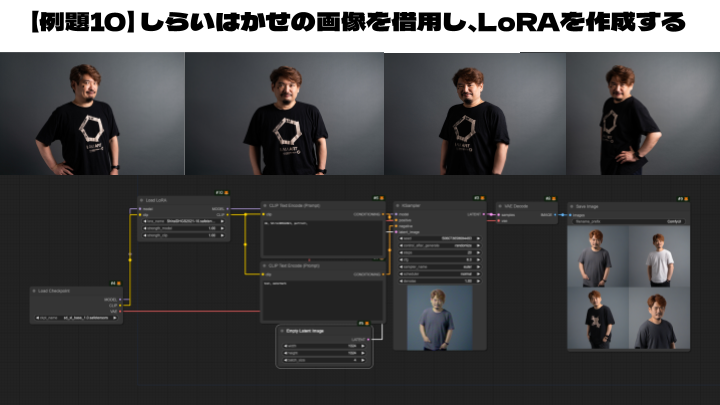

In [ ]:
#@markdown ### 📂 AICUデータセットの準備
#@markdown あなたの Google Driveに接続し、マイドライブのトップ「Loras」フォルダに[サンプルデータセット](https://huggingface.co/AICU/SDXL-LoRA/tree/main)をダウンロードし、展開します。
#@markdown 画像の利用に関しては、著作権侵害、肖像権侵害、名誉毀損にあたる使用をしないことを遵守してください。学習や実験に使う以外の目的、商用目的での使用は coloso@aicu.ai に問い合わせてください。

import os, zipfile

download_from = "https://huggingface.co/AICU/SDXL-LoRA/resolve/main/ShiraiLoRA.zip" #@param  {type:"string"}
zip = "/content/drive/MyDrive/Loras/ShiraiLoRA.zip" #@param {type:"string"}
extract_to = "/content/drive/MyDrive/Loras/ShiraiDHGS-SDXL/dataset" #@param {type:"string"}

if not os.path.exists('/content/drive'):
  from google.colab import drive
  print("📂 Google Drive に接続中...")
  drive.mount('/content/drive')

!mkdir /content/drive/MyDrive/Loras
!mkdir -p '{extract_to}'
%cd /content/drive/MyDrive/Loras
!wget '{download_from}' -O '{zip}'
#指定ディレクトリにフラットに展開したい
!unzip -j '{zip}' -d '{extract_to}'

#os.makedirs(extract_to, exist_ok=True)
#with zipfile.ZipFile(zip, 'r') as f:
#  f.extractall(extract_to)
#
##print("✅ Done")


# 🌟 XL Lora Trainer by Hollowstrawberry

❗ **Colab Premium is recommended.** Ideally you'd be changing the runtime to an A100 and use the maximum batch size.  
However you can still train for free if you load a diffusers model, it will just take much longer.  


This colab is based on the work of [Kohya-ss](https://github.com/kohya-ss/sd-scripts) and [Linaqruf](https://github.com/Linaqruf/kohya-trainer). Thank you!

### ⭕ Disclaimer
The purpose of this document is to research bleeding-edge technologies in the field of machine learning inference.  
Please read and follow the [Google Colab guidelines](https://research.google.com/colaboratory/faq.html) and its [Terms of Service](https://research.google.com/colaboratory/tos_v3.html).

| |GitHub|🇬🇧 English|🇪🇸 Spanish|
|:--|:-:|:-:|:-:|
| 🏠 **Homepage** | [![GitHub](https://raw.githubusercontent.com/hollowstrawberry/kohya-colab/main/assets/github.svg)](https://github.com/hollowstrawberry/kohya-colab) | | |
| 📊 **Dataset Maker** | [![GitHub](https://raw.githubusercontent.com/hollowstrawberry/kohya-colab/main/assets/github.svg)](https://github.com/hollowstrawberry/kohya-colab/blob/main/Dataset_Maker.ipynb) | [![Open in Colab](https://raw.githubusercontent.com/hollowstrawberry/kohya-colab/main/assets/colab-badge.svg)](https://colab.research.google.com/github/hollowstrawberry/kohya-colab/blob/main/Dataset_Maker.ipynb) | [![Abrir en Colab](https://raw.githubusercontent.com/hollowstrawberry/kohya-colab/main/assets/colab-badge-spanish.svg)](https://colab.research.google.com/github/hollowstrawberry/kohya-colab/blob/main/Spanish_Dataset_Maker.ipynb) |
| ⭐ **Lora Trainer** | [![GitHub](https://raw.githubusercontent.com/hollowstrawberry/kohya-colab/main/assets/github.svg)](https://github.com/hollowstrawberry/kohya-colab/blob/main/Lora_Trainer.ipynb) | [![Open in Colab](https://raw.githubusercontent.com/hollowstrawberry/kohya-colab/main/assets/colab-badge.svg)](https://colab.research.google.com/github/hollowstrawberry/kohya-colab/blob/main/Lora_Trainer.ipynb) | [![Abrir en Colab](https://raw.githubusercontent.com/hollowstrawberry/kohya-colab/main/assets/colab-badge-spanish.svg)](https://colab.research.google.com/github/hollowstrawberry/kohya-colab/blob/main/Spanish_Lora_Trainer.ipynb) |
| 🌟 **XL Lora Trainer** | [![GitHub](https://raw.githubusercontent.com/hollowstrawberry/kohya-colab/main/assets/github.svg)](https://github.com/hollowstrawberry/kohya-colab/blob/main/Lora_Trainer_XL.ipynb) | [![Open in Colab](https://raw.githubusercontent.com/hollowstrawberry/kohya-colab/main/assets/colab-badge.svg)](https://colab.research.google.com/github/hollowstrawberry/kohya-colab/blob/main/Lora_Trainer_XL.ipynb) |  |

In [ ]:
import os
import re
import toml
import pathlib
from time import time
from IPython.display import Markdown, display

# These carry information from past executions
if "model_url" in globals():
  old_model_url = model_url
else:
  old_model_url = None
if "dependencies_installed" not in globals():
  dependencies_installed = False
if "model_file" not in globals():
  model_file = None

# These may be set by other cells, some are legacy
if "custom_dataset" not in globals():
  custom_dataset = None
if "override_dataset_config_file" not in globals():
  override_dataset_config_file = None
if "continue_from_lora" not in globals():
  continue_from_lora = ""
if "override_config_file" not in globals():
  override_config_file = None

COLAB = True
SOURCE = "https://github.com/qaneel/kohya-trainer"
COMMIT = None
BETTER_EPOCH_NAMES = True
LOAD_TRUNCATED_IMAGES = True
try:
  LOWRAM = int(next(line.split()[1] for line in open('/proc/meminfo') if "MemTotal" in line)) / (1024**2) < 15
except:
  LOWRAM = False

#@title ## 🚩 Start Here

#@markdown ### ▶️ Setup
#@markdown Your project name will be the same as the folder containing your images. Spaces aren't allowed.
project_name = "ShiraiDHGS-SDXL" #@param {type:"string"}
project_name = project_name.strip()
#@markdown The folder structure doesn't matter and is purely for comfort. Make sure to always pick the same one. I like organizing by project.
folder_structure = "Organize by project (MyDrive/Loras/project_name/dataset)" #@param ["Organize by category (MyDrive/lora_training/datasets/project_name)", "Organize by project (MyDrive/Loras/project_name/dataset)"]
#@markdown Decide the model that will be downloaded and used for training. You can also choose your own by pasting its download link, or a file in your Google Drive starting with `/content/drive/MyDrive`.
training_model = "Stable Diffusion XL 1.0 base" #@param ["Pony Diffusion V6 XL", "Illustrious XL 0.1", "Animagine XL V3", "Stable Diffusion XL 1.0 base"]
optional_custom_training_model = "" #@param {type:"string"}
#@markdown Using a diffusers model utilizes less resources. The 3 options above will work with or without diffusers.
load_diffusers = True #@param {type:"boolean"}
#@markdown Use wandb if you want to visualize the progress of your training over time.
wandb_key = "" #@param {type:"string"}

if optional_custom_training_model:
  model_url = optional_custom_training_model
elif "Pony" in training_model:
  if load_diffusers:
    model_url = "https://huggingface.co/hollowstrawberry/67AB2F"
  else:
    model_url = "https://civitai.com/api/download/models/290640"
  model_file = "/content/ponyDiffusionV6XL.safetensors"
elif "Animagine" in training_model:
  if load_diffusers:
    model_url = "https://huggingface.co/cagliostrolab/animagine-xl-3.0"
  else:
    model_url = "https://civitai.com/api/download/models/293564"
  model_file = "/content/animagineXLV3.safetensors"
elif "Illustrious" in training_model:
  if load_diffusers:
    model_url = "https://huggingface.co/OnomaAIResearch/Illustrious-xl-early-release-v0"
  else:
    model_url = "https://huggingface.co/OnomaAIResearch/Illustrious-xl-early-release-v0/resolve/main/Illustrious-XL-v0.1.safetensors"
else:
  if load_diffusers:
    model_url = "https://huggingface.co/stabilityai/stable-diffusion-xl-base-1.0/"
  else:
    model_url = "https://huggingface.co/stabilityai/stable-diffusion-xl-base-1.0/resolve/main/sd_xl_base_1.0.safetensors"

if load_diffusers:
  vae_file= "stabilityai/sdxl-vae"
else:
  vae_url = "https://huggingface.co/stabilityai/sdxl-vae/resolve/main/sdxl_vae.safetensors"
  vae_file = "/content/sdxl_vae.safetensors"

model_url = model_url.strip()

#@markdown ### ▶️ Processing
resolution = 1024 #param {type:"slider", min:768, max:1536, step:128}
caption_extension = ".txt" #@param [".txt", ".caption"]
#@markdown Shuffling anime tags in place improves learning and prompting. An activation tag goes at the start of every text file and will not be shuffled.<p>
shuffle_tags = True #@param {type:"boolean"}
shuffle_caption = shuffle_tags
activation_tags = "1" #@param [0,1,2,3]
keep_tokens = int(activation_tags)

#@markdown ### ▶️ Steps <p>
#@markdown Your images will repeat this number of times during training. I recommend that your images multiplied by their repeats is between 200 and 400.
#@markdown トレーニング中に画像はこの回数繰り返されます。画像の数とその繰り返し回数を掛けた値が 200 ～ 400 になるようにすることをお勧めします。
num_repeats = 100 #@param {type:"number"}
#@markdown Choose how long you want to train for. A good starting point is around 10 epochs or around 2000 steps.<p>
#@markdown One epoch is a number of steps equal to: your number of images multiplied by their repeats, divided by batch size. <p>
#@markdown トレーニングする期間を選択します。適切な開始点は、約 10 エポックまたは約 2000 ステップです。<p>
#@markdown 1 エポックは、画像の数に 繰り返し回数 を掛け、バッチサイズ で割った値に等しい ステップ数 です。<p>
preferred_unit = "Epochs" #@param ["Epochs", "Steps"]
how_many = 10 #@param {type:"number"}
max_train_epochs = how_many if preferred_unit == "Epochs" else None
max_train_steps = how_many if preferred_unit == "Steps" else None
#@markdown Saving more epochs will let you compare your Lora's progress better.
save_every_n_epochs = 1 #@param {type:"number"}
keep_only_last_n_epochs = 10 #@param {type:"number"}
if not save_every_n_epochs:
  save_every_n_epochs = max_train_epochs
if not keep_only_last_n_epochs:
  keep_only_last_n_epochs = max_train_epochs

#@markdown ### ▶️ Learning
#@markdown The learning rate is the most important for your results. If your Lora produces black images, lower the unet and text encoder to 1e-4 and 1e-5 respectively, or even lower. <p>
#@markdown If you're training a style you can choose to set the text encoder to 0.
#@markdown 学習率は結果にとって最も重要です。Lora が黒い画像を生成する場合は、unet とテキスト エンコーダーをそれぞれ 1e-4 と 1e-5 に下げるか、さらに下げてください。<p>
#@markdown スタイルをトレーニングする場合は、テキスト エンコーダーを 0 に設定できます。
unet_lr = 1e-4 #@param {type:"number"}
text_encoder_lr = 1e-4 #@param {type:"number"}
#@markdown The scheduler is the algorithm that guides the learning rate. If you're not sure, pick `constant` and ignore the number. I personally recommend `cosine_with_restarts` with 3 restarts.
lr_scheduler = "cosine_with_restarts" #@param ["constant", "cosine", "cosine_with_restarts", "constant_with_warmup", "linear", "polynomial"]
lr_scheduler_number = 3 #@param {type:"number"}
#@markdown Steps spent "warming up" the learning rate during training for efficiency. I recommend leaving it at 5%.
lr_warmup_ratio = 0.05 #@param {type:"slider", min:0.0, max:0.2, step:0.01}
lr_warmup_steps = 0
#@markdown Adjusts loss over time, makes learning much more efficient. The paper recommends 5.0, I recommend 8.0 for anime. Higher value makes it less strict. Set to 0 to disable.
min_snr_gamma = 8.0 #@param {type:"slider", min:0.0, max:16.0, step:0.5}
#@markdown Multinoise may help with color balance (darker darks, lighter lights).
multinoise = True #@param {type:"boolean"}

#@markdown ### ▶️ Structure
#@markdown LoRA is the classic type and good for a variety of purposes. LoCon is good with artstyles as it has more layers to learn more aspects of the dataset.
lora_type = "LoRA" #@param ["LoRA", "LoCon"]

#@markdown Below are some recommended XL values for the following settings:

#@markdown | type | network_dim | network_alpha | conv_dim | conv_alpha |
#@markdown | :---: | :---: | :---: | :---: | :---: |
#@markdown | Regular LoRA | 8 | 4 |   |   |
#@markdown | Style LoCon | 16 | 8 | 16 | 8 |

#@markdown More dim means larger Lora, it can hold more information but more isn't always better.
network_dim = 8 #@param {type:"slider", min:1, max:32, step:1}
network_alpha = 4 #@param {type:"slider", min:1, max:32, step:1}
#@markdown The following two values only apply to the additional layers of LoCon.
conv_dim = 4 #@param {type:"slider", min:1, max:32, step:1}
conv_alpha = 1 #@param {type:"slider", min:1, max:32, step:1}

network_module = "networks.lora"
network_args = None
if lora_type.lower() == "locon":
  network_args = [f"conv_dim={conv_dim}", f"conv_alpha={conv_alpha}"]

#@markdown ### ▶️ Training
#@markdown Adjust these parameters depending on your colab configuration.
#@markdown If you're using the free tier you should select a diffusers model at the top of this cell.
#@markdown
#@markdown Higher batch size is often faster but uses more memory.
train_batch_size = 4 #@param {type:"slider", min:1, max:16, step:1}
#@markdown I have found no substantial difference between sdpa and xformers.
cross_attention = "sdpa" #@param ["sdpa", "xformers"]
#@markdown If you're on an A100 you should enable bf16.
#@markdown A100 を使用している場合は、bf16 を有効にする必要があります。
mixed_precision = "fp16" #@param ["bf16", "fp16"]
#@markdown Caching latents to drive will add a 250KB file next to each image but will use considerably less memory.
cache_latents = True #@param {type:"boolean"}
cache_latents_to_drive = True #@param {type:"boolean"}
#@markdown The following option will turn off shuffle_tags and disable text encoder training.
cache_text_encoder_outputs  = False  # @param {type:"boolean"}

#@markdown ### ▶️ Advanced
#@markdown The optimizer is the algorithm used for training. AdanW8Bit is the default and works great, while Prodigy manages learning rate automatically and may have several advantages such as training faster due to needing less steps as well as working better for small datasets.
optimizer = "AdamW8bit" #@param ["AdamW8bit", "Prodigy", "DAdaptation", "DadaptAdam", "DadaptLion", "AdamW", "Lion", "SGDNesterov", "SGDNesterov8bit", "AdaFactor"]
#@markdown Recommended args for AdamW8bit: `weight_decay=0.1 betas=[0.9,0.99]`<p>
#@markdown Recommended args for Prodigy: `decouple=True weight_decay=0.01 betas=[0.9,0.999] d_coef=2 use_bias_correction=True safeguard_warmup=True`<p>
#markdown Recommended args for CAME: `weight_decay=0.04`
optimizer_args = "weight_decay=0.1 betas=[0.9,0.99]" #@param {type:"string"}
optimizer_args = [a.strip() for a in optimizer_args.split(' ') if a]
#@markdown If Dadapt or Prodigy are selected and the recommended box is checked, the following recommended values will override any previous settings:<p>
#@markdown `unet_lr=0.75`, `text_encoder_lr=0.75`, `network_alpha=network_dim`<p>
#markdown If CAME + REX is selected and the recommended box is checked, the following recommended values will override any previous settings:<p>
#markdown `unet_lr=1e-4`, `text_encoder_lr=1e-6, betas=default_came_betas`
recommended_values = True #@param {type:"boolean"}

if any(opt in optimizer.lower() for opt in ["dadapt", "prodigy"]):
  if recommended_values:
    unet_lr = 0.75
    text_encoder_lr = 0.75
    network_alpha = network_dim
elif "CAME" in optimizer:
  optimizer = "CAME"
  lr_scheduler = "REX"
  if recommended_values:
    unet_lr = 1e-4
    text_encoder_lr = 1e-6
    for i in range(len(optimizer_args)):
      if "betas" in optimizer_args[i]:
        optimizer_args.pop(i)
        break

lr_scheduler_num_cycles = lr_scheduler_number if lr_scheduler == "cosine_with_restarts" else 0
lr_scheduler_power = lr_scheduler_number if lr_scheduler == "polynomial" else 0


#@markdown ### ▶️ Ready
#@markdown You can now run this cell to cook your Lora. Good luck! <p>


# 👩‍💻 Cool code goes here

root_dir = "/content" if COLAB else pathlib.Path.home() / "Loras"
deps_dir = os.path.join(root_dir, "deps")
repo_dir = os.path.join(root_dir, "kohya-trainer")

if "/Loras" in folder_structure:
  main_dir      = os.path.join(root_dir, "drive/MyDrive/Loras") if COLAB else root_dir
  log_folder    = os.path.join(main_dir, "_logs")
  config_folder = os.path.join(main_dir, project_name)
  images_folder = os.path.join(main_dir, project_name, "dataset")
  output_folder = os.path.join(main_dir, project_name, "output")
else:
  main_dir      = os.path.join(root_dir, "drive/MyDrive/lora_training") if COLAB else root_dir
  images_folder = os.path.join(main_dir, "datasets", project_name)
  output_folder = os.path.join(main_dir, "output", project_name)
  config_folder = os.path.join(main_dir, "config", project_name)
  log_folder    = os.path.join(main_dir, "log")

config_file = os.path.join(config_folder, "training_config.toml")
dataset_config_file = os.path.join(config_folder, "dataset_config.toml")
accelerate_config_file = os.path.join(repo_dir, "accelerate_config/config.yaml")

def install_dependencies():
  os.chdir(root_dir)
  !git clone {SOURCE} {repo_dir}
  os.chdir(repo_dir)
  if COMMIT:
    !git reset --hard {COMMIT}
  !wget https://raw.githubusercontent.com/hollowstrawberry/kohya-colab/main/train_network_xl_wrapper.py -q -O train_network_xl_wrapper.py
  !wget https://raw.githubusercontent.com/hollowstrawberry/kohya-colab/main/dracula.py -q -O dracula.py

  !apt -y update -qq
  !apt -y install aria2 -qq
  !pip install torch==2.5.1+cu121 accelerate==0.19.0 transformers==4.30.2 diffusers==0.18.2 \
    bitsandbytes==0.40.0.post4 opencv-python jax==0.4.23 jaxlib==0.4.23 \
    pytorch-lightning==1.9.0 voluptuous==0.13.1 toml==0.10.2 ftfy==6.1.1 einops==0.6.0 \
    safetensors pygments huggingface-hub==0.22.0 wandb invisible-watermark==0.2.0 open-clip-torch==2.20.0 \
    dadaptation==3.1 prodigyopt==1.0 lion-pytorch==0.1.2
  !pip install -e .
  if cross_attention == "xformers":
    !pip install -q xformers==0.0.26.dev778
  if "CAME" in optimizer:
    !pip install came-pytorch
    !wget https://raw.githubusercontent.com/hollowstrawberry/kohya-colab/main/train_util.py -q -O library/train_util.py

  # patch kohya for minor stuff
  if LOWRAM:
    !sed -i "s@cpu@cuda@" library/model_util.py
  if LOAD_TRUNCATED_IMAGES:
    !sed -i 's/from PIL import Image/from PIL import Image, ImageFile\nImageFile.LOAD_TRUNCATED_IMAGES=True/g' library/train_util.py # fix truncated jpegs error
  if BETTER_EPOCH_NAMES:
    !sed -i 's/{:06d}/{:02d}/g' library/train_util.py # make epoch names shorter
    !sed -i 's/"." + args.save_model_as)/"-{:02d}.".format(num_train_epochs) + args.save_model_as)/g' train_network.py # name of the last epoch will match the rest

  from accelerate.utils import write_basic_config
  if not os.path.exists(accelerate_config_file):
    write_basic_config(save_location=accelerate_config_file)

  os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
  os.environ["BITSANDBYTES_NOWELCOME"] = "1"
  os.environ["SAFETENSORS_FAST_GPU"] = "1"

def validate_dataset():
  global lr_warmup_steps, lr_warmup_ratio, caption_extension, keep_tokens, model_url
  supported_types = (".png", ".jpg", ".jpeg", ".webp", ".bmp")

  if model_url.startswith("/content/drive/") and not os.path.exists(model_url):
    print("💥 Error: The custom training model you specified was not found in your Google Drive.")
    return

  print("\n💿 Checking dataset...")
  if not project_name.strip() or any(c in project_name for c in " .()\"'\\/"):
    print("💥 Error: Please choose a valid project name.")
    return

  # Find the folders and files
  if custom_dataset:
    try:
      datconf = toml.loads(custom_dataset)
      datasets = [d for d in datconf["datasets"][0]["subsets"]]
    except:
      print(f"💥 Error: Your custom dataset is invalid or contains an error! Please check the original template.")
      return
    reg = [d.get("image_dir") for d in datasets if d.get("is_reg", False)]
    datasets_dict = {d["image_dir"]: d["num_repeats"] for d in datasets}
    folders = datasets_dict.keys()
    files = [f for folder in folders for f in os.listdir(folder)]
    images_repeats = {folder: (len([f for f in os.listdir(folder) if f.lower().endswith(supported_types)]), datasets_dict[folder]) for folder in folders}
  else:
    reg = []
    folders = [images_folder]
    files = os.listdir(images_folder)
    images_repeats = {images_folder: (len([f for f in files if f.lower().endswith(supported_types)]), num_repeats)}

  # Validation
  for folder in folders:
    if not os.path.exists(folder):
      print(f"💥 Error: The folder {folder.replace('/content/drive/', '')} doesn't exist.")
      return
  for folder, (img, rep) in images_repeats.items():
    if not img:
      print(f"💥 Error: Your {folder.replace('/content/drive/', '')} folder is empty.")
      return
  test_files = []
  for f in files:
    if not f.lower().endswith((caption_extension, ".npz")) and not f.lower().endswith(supported_types):
      print(f"💥 Error: Invalid file in dataset: \"{f}\". Aborting.")
      return
    for ff in test_files:
      if f.endswith(supported_types) and ff.endswith(supported_types) \
          and os.path.splitext(f)[0] == os.path.splitext(ff)[0]:
        print(f"💥 Error: The files {f} and {ff} cannot have the same name. Aborting.")
        return
    test_files.append(f)

  if caption_extension and not [txt for txt in files if txt.lower().endswith(caption_extension)]:
    caption_extension = ""
  if continue_from_lora and not (continue_from_lora.endswith(".safetensors") and os.path.exists(continue_from_lora)):
    print(f"💥 Error: Invalid path to existing Lora. Example: /content/drive/MyDrive/Loras/example.safetensors")
    return

  # Pretty stuff

  pre_steps_per_epoch = sum(img*rep for (img, rep) in images_repeats.values())
  steps_per_epoch = pre_steps_per_epoch/train_batch_size
  total_steps = max_train_steps or int(max_train_epochs*steps_per_epoch)
  estimated_epochs = int(total_steps/steps_per_epoch)
  lr_warmup_steps = int(total_steps*lr_warmup_ratio)

  for folder, (img, rep) in images_repeats.items():
    print("📁"+folder.replace("/content/drive/", "") + (" (Regularization)" if folder in reg else ""))
    print(f"📈 Found {img} images with {rep} repeats, equaling {img*rep} steps.")
  print(f"📉 Divide {pre_steps_per_epoch} steps by {train_batch_size} batch size to get {steps_per_epoch} steps per epoch.")
  if max_train_epochs:
    print(f"🔮 There will be {max_train_epochs} epochs, for around {total_steps} total training steps.")
  else:
    print(f"🔮 There will be {total_steps} steps, divided into {estimated_epochs} epochs and then some.")

  if total_steps > 10000:
    print("💥 Error: Your total steps are too high. You probably made a mistake. Aborting...")
    return

  return True

def create_config():
  global dataset_config_file, config_file, model_file

  if override_config_file:
    config_file = override_config_file
    print(f"\n⭕ Using custom config file {config_file}")
  else:
    config_dict = {
      "network_arguments": {
        "unet_lr": unet_lr,
        "text_encoder_lr": text_encoder_lr if not cache_text_encoder_outputs else 0,
        "network_dim": network_dim,
        "network_alpha": network_alpha,
        "network_module": network_module,
        "network_args": network_args,
        "network_train_unet_only": text_encoder_lr == 0 or cache_text_encoder_outputs,
        "network_weights": continue_from_lora if continue_from_lora else None
      },
      "optimizer_arguments": {
        "learning_rate": unet_lr,
        "lr_scheduler": lr_scheduler,
        "lr_scheduler_num_cycles": lr_scheduler_num_cycles if lr_scheduler == "cosine_with_restarts" else None,
        "lr_scheduler_power": lr_scheduler_power if lr_scheduler == "polynomial" else None,
        "lr_warmup_steps": lr_warmup_steps if lr_scheduler != "constant" else None,
        "optimizer_type": optimizer,
        "optimizer_args": optimizer_args if optimizer_args else None,
      },
      "training_arguments": {
        "pretrained_model_name_or_path": model_file,
        "vae": vae_file,
        "max_train_steps": max_train_steps,
        "max_train_epochs": max_train_epochs,
        "train_batch_size": train_batch_size,
        "seed": 42,
        "max_token_length": 225,
        "xformers": cross_attention == "xformers",
        "sdpa": cross_attention == "sdpa",
        "min_snr_gamma": min_snr_gamma if min_snr_gamma > 0 else None,
        "lowram": LOWRAM,
        "no_half_vae": True,
        "gradient_checkpointing": True,
        "gradient_accumulation_steps": 1,
        "max_data_loader_n_workers": 8,
        "persistent_data_loader_workers": True,
        "mixed_precision": mixed_precision,
        "full_bf16": mixed_precision == "bf16",
        "cache_latents": cache_latents,
        "cache_latents_to_disk": cache_latents_to_drive,
        "cache_text_encoder_outputs": cache_text_encoder_outputs,
        "min_timestep": 0,
        "max_timestep": 1000,
        "prior_loss_weight": 1.0,
        "multires_noise_iterations": 6 if multinoise else None,
        "multires_noise_discount": 0.3 if multinoise else None,
      },
      "saving_arguments": {
        "save_precision": "fp16",
        "save_model_as": "safetensors",
        "save_every_n_epochs": save_every_n_epochs,
        "save_last_n_epochs": keep_only_last_n_epochs,
        "output_name": project_name,
        "output_dir": output_folder,
        "log_prefix": project_name,
        "logging_dir": log_folder,
        "wandb_api_key": wandb_key if wandb_key else None,
        "log_with": "wandb" if wandb_key else None,
      }
    }

    for key in config_dict:
      if isinstance(config_dict[key], dict):
        config_dict[key] = {k: v for k, v in config_dict[key].items() if v is not None}

    with open(config_file, "w") as f:
      f.write(toml.dumps(config_dict))
    print(f"\n📄 Config saved to {config_file}")

  if override_dataset_config_file:
    dataset_config_file = override_dataset_config_file
    print(f"⭕ Using custom dataset config file {dataset_config_file}")
  else:
    dataset_config_dict = {
      "general": {
        "resolution": resolution,
        "shuffle_caption": shuffle_caption and not cache_text_encoder_outputs,
        "keep_tokens": keep_tokens,
        "flip_aug": False,
        "caption_extension": caption_extension,
        "enable_bucket": True,
        "bucket_no_upscale": False,
        "bucket_reso_steps": 64,
        "min_bucket_reso": 256,
        "max_bucket_reso": 4096,
      },
      "datasets": toml.loads(custom_dataset)["datasets"] if custom_dataset else [
        {
          "subsets": [
            {
              "num_repeats": num_repeats,
              "image_dir": images_folder,
              "class_tokens": None if caption_extension else project_name
            }
          ]
        }
      ]
    }

    for key in dataset_config_dict:
      if isinstance(dataset_config_dict[key], dict):
        dataset_config_dict[key] = {k: v for k, v in dataset_config_dict[key].items() if v is not None}

    with open(dataset_config_file, "w") as f:
      f.write(toml.dumps(dataset_config_dict))
    print(f"📄 Dataset config saved to {dataset_config_file}")

def download_model():
  global old_model_url, model_url, model_file, vae_url, vae_file
  real_model_url = model_url  # There was a reason for having a separate variable but I forgot what it was.

  if real_model_url.startswith("/content/drive/"):
    # Local model, already checked to exist
    model_file = real_model_url
    print(f"📁 Using local model file: {model_file}")
    # Validation
    if model_file.lower().endswith(".safetensors"):
      from safetensors.torch import load_file as load_safetensors
      try:
        test = load_safetensors(model_file)
        del test
      except:
        return False
    elif model_file.lower().endswith(".ckpt"):
      from torch import load as load_ckpt
      try:
        test = load_ckpt(model_file)
        del test
      except:
        return False
    return True

  else:
    # Downloadable model
    if load_diffusers:
      if 'huggingface.co' in real_model_url:
          match = re.search(r'huggingface\.co/([^/]+)/([^/]+)', real_model_url)
          if match:
              username = match.group(1)
              model_name = match.group(2)
              model_file = f"{username}/{model_name}"
              from huggingface_hub import HfFileSystem
              fs = HfFileSystem()
              existing_folders = set(fs.ls(model_file, detail=False))
              necessary_folders = [ "scheduler", "text_encoder", "text_encoder_2", "tokenizer", "tokenizer_2", "unet", "vae" ]
              if all(f"{model_file}/{folder}" in existing_folders for folder in necessary_folders):
                print("🍃 Diffusers model identified.")  # Will be handled by kohya
                return True
      raise ValueError("💥 Failed to load Diffusers model. If this model is not Diffusers, have you tried turning it off at the top of the colab?")

    # Define local filename
    if not model_file:
      if real_model_url.lower().endswith((".ckpt", ".safetensors")):
        model_file = f"/content{real_model_url[real_model_url.rfind('/'):]}"
      else:
        model_file = "/content/downloaded_model.safetensors"
        if os.path.exists(model_file):
          !rm "{model_file}"

    # HuggingFace
    if m := re.search(r"(?:https?://)?(?:www\.)?huggingface\.co/[^/]+/[^/]+/blob", real_model_url):
      real_model_url = real_model_url.replace("blob", "resolve")
    # Civitai
    elif m := re.search(r"(?:https?://)?(?:www\\.)?civitai\.com/models/([0-9]+)(/[A-Za-z0-9-_]+)?", real_model_url):
      if m.group(2):
        model_file = f"/content{m.group(2)}.safetensors"
      if m := re.search(r"modelVersionId=([0-9]+)", real_model_url):
        real_model_url = f"https://civitai.com/api/download/models/{m.group(1)}"
      else:
        raise ValueError("💥 optional_custom_training_model contains a civitai link, but the link doesn't include a modelVersionId. You can also right click the download button to copy the direct download link.")

    # Download checkpoint
    !aria2c "{real_model_url}" --console-log-level=warn -c -s 16 -x 16 -k 10M -d / -o "{model_file}"

    # Download VAE
    if not os.path.exists(vae_file):
      !aria2c "{vae_url}" --console-log-level=warn -c -s 16 -x 16 -k 10M -d / -o "{vae_file}"

    # Validation

    if model_file.lower().endswith(".safetensors"):
      from safetensors.torch import load_file as load_safetensors
      try:
        test = load_safetensors(model_file)
        del test
      except:
        new_model_file = os.path.splitext(model_file)[0]+".ckpt"
        !mv "{model_file}" "{new_model_file}"
        model_file = new_model_file
        print(f"Renamed model to {os.path.splitext(model_file)[0]}.ckpt")

    if model_file.lower().endswith(".ckpt"):
      from torch import load as load_ckpt
      try:
        test = load_ckpt(model_file)
        del test
      except:
        return False

  return True

def main():
  global dependencies_installed

  if COLAB and not os.path.exists('/content/drive'):
    from google.colab import drive
    print("📂 Connecting to Google Drive...")
    drive.mount('/content/drive')

  for dir in (main_dir, deps_dir, repo_dir, log_folder, images_folder, output_folder, config_folder):
    os.makedirs(dir, exist_ok=True)

  if not validate_dataset():
    return

  if not dependencies_installed:
    print("\n🏭 Installing dependencies...\n")
    t0 = time()
    install_dependencies()
    t1 = time()
    dependencies_installed = True
    print(f"\n✅ Installation finished in {int(t1-t0)} seconds.")
  else:
    print("\n✅ Dependencies already installed.")

  if old_model_url != model_url or not model_file or not os.path.exists(model_file):
    print("\n🔄 Getting model...")
    if not download_model():
      print("\n💥 Error: The model you specified is invalid or corrupted."
            "\nIf you're using an URL, please check that the model is accessible without being logged in."
            "\nYou can try civitai or huggingface URLs, or a path in your Google Drive starting with /content/drive/MyDrive")
      return
    print()
  else:
    print("\n🔄 Model already downloaded.\n")

  create_config()

  print("\n⭐ Starting trainer...\n")
  os.chdir(repo_dir)

  !accelerate launch --quiet --config_file={accelerate_config_file} --num_cpu_threads_per_process=1 train_network_xl_wrapper.py --dataset_config={dataset_config_file} --config_file={config_file}

  if not get_ipython().__dict__['user_ns']['_exit_code']:
    display(Markdown("### ✅ Done! [Go download your Lora from Google Drive](https://drive.google.com/drive/my-drive)\n"
                     "### There will be several files, you should try the latest version (the file with the largest number next to it)"))

main()


## *️⃣ Extras

You can run these before starting the training.

### 📚 Multiple folders in dataset
Below is a template allowing you to define multiple folders in your dataset. You must include the location of each folder and you can set different number of repeats for each one. To add more folders simply copy and paste the sections starting with `[[datasets.subsets]]`.

When enabling this, the number of repeats set in the main cell will be ignored, and the main folder set by the project name will also be ignored.

You can make one of them a regularization folder by adding `is_reg = true`  
You can also set different `keep_tokens`, `flip_aug`, etc.

In [ ]:
custom_dataset = """
[[datasets]]

[[datasets.subsets]]
image_dir = "/content/drive/MyDrive/Loras/example/dataset/good_images"
num_repeats = 3

[[datasets.subsets]]
image_dir = "/content/drive/MyDrive/Loras/example/dataset/normal_images"
num_repeats = 1

"""

In [ ]:
custom_dataset = None

In [ ]:
#@markdown ### 📂 Unzip dataset
#@markdown It's much slower to upload individual files to your Drive, so you may want to upload a zip if you have your dataset in your computer.
zip = "/content/drive/MyDrive/my_dataset.zip" #@param {type:"string"}
extract_to = "/content/drive/MyDrive/Loras/example/dataset" #@param {type:"string"}

import os, zipfile

if not os.path.exists('/content/drive'):
  from google.colab import drive
  print("📂 Connecting to Google Drive...")
  drive.mount('/content/drive')

os.makedirs(extract_to, exist_ok=True)

with zipfile.ZipFile(zip, 'r') as f:
  f.extractall(extract_to)

print("✅ Done")


In [ ]:
#@markdown ### 🔢 Count datasets
#@markdown Google Drive makes it impossible to count the files in a folder, so this will show you the file counts in all folders and subfolders.
folder = "/content/drive/MyDrive/Loras" #@param {type:"string"}

import os
from google.colab import drive

if not os.path.exists('/content/drive'):
    print("📂 Connecting to Google Drive...\n")
    drive.mount('/content/drive')

tree = {}
exclude = ("_logs", "/output")
for i, (root, dirs, files) in enumerate(os.walk(folder, topdown=True)):
  dirs[:] = [d for d in dirs if all(ex not in d for ex in exclude)]
  images = len([f for f in files if f.lower().endswith((".png", ".jpg", ".jpeg"))])
  captions = len([f for f in files if f.lower().endswith(".txt")])
  others = len(files) - images - captions
  path = root[folder.rfind("/")+1:]
  tree[path] = None if not images else f"{images:>4} images | {captions:>4} captions |"
  if tree[path] and others:
    tree[path] += f" {others:>4} other files"

pad = max(len(k) for k in tree)
print("\n".join(f"📁{k.ljust(pad)} | {v}" for k, v in tree.items() if v))


In [ ]:
#@markdown ### ↪️ Continue

#@markdown Here you can write a path in your Google Drive to load an existing Lora file to continue training on.<p>
#@markdown **Warning:** It's not the same as one long training session. The epochs start from scratch, and it may have worse results.
continue_from_lora = "" #@param {type:"string"}
if continue_from_lora and not continue_from_lora.startswith("/content/drive/MyDrive"):
  import os
  continue_from_lora = os.path.join("/content/drive/MyDrive", continue_from_lora)


# 📈 Plot training results
You can do this after running the trainer. You don't need this unless you know what you're doing.  
The first cell below may fail to load all your logs. Keep trying the second cell until all data has loaded.

In [ ]:
%load_ext tensorboard
%tensorboard --logdir={log_folder}/

In [ ]:
from tensorboard import notebook
notebook.display(port=6006, height=800)